In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def run_loss_harvest_backtest(symbol='BTC-USD', initial_investment=100000, loss_threshold=-0.05, start_date='2014-01-01'):
    """
    Run a tax loss harvesting backtest on cryptocurrency data.
    
    Parameters:
    - symbol: Trading symbol (default: 'BTC-USD')
    - initial_investment: Starting investment amount (default: $100,000)
    - loss_threshold: Threshold for harvesting losses (default: -5%)
    - start_date: Start date for backtest
    """
    # Download data
    btc = yf.download(symbol, start=start_date, end=datetime.now().strftime('%Y-%m-%d'))
    
    # Initialize tracking variables
    portfolio = pd.DataFrame(index=btc.index)
    portfolio['Price'] = btc['Adj Close']
    portfolio['Holdings'] = 0.0
    portfolio['Cash'] = 0.0
    portfolio['Portfolio_Value'] = 0.0
    portfolio['Cost_Basis'] = 0.0
    portfolio['Realized_Losses'] = 0.0
    
    # Initial purchase
    initial_price = portfolio['Price'].iloc[0]
    initial_coins = initial_investment / initial_price
    current_cost_basis = initial_price
    
    # Set initial positions
    portfolio.loc[portfolio.index[0], 'Holdings'] = initial_coins
    portfolio.loc[portfolio.index[0], 'Cash'] = 0
    portfolio.loc[portfolio.index[0], 'Portfolio_Value'] = initial_investment
    portfolio.loc[portfolio.index[0], 'Cost_Basis'] = current_cost_basis
    
    # Run simulation
    for i in range(1, len(portfolio)):
        current_price = portfolio['Price'].iloc[i]
        prev_holdings = portfolio['Holdings'].iloc[i-1]
        
        # Calculate current returns relative to cost basis
        current_return = (current_price - current_cost_basis) / current_cost_basis
        
        # Check if loss harvest threshold is met
        if current_return <= loss_threshold:
            # Record realized loss
            realized_loss = (current_price - current_cost_basis) * prev_holdings
            portfolio.loc[portfolio.index[i], 'Realized_Losses'] = realized_loss
            
            # Sell and immediately rebuy (same number of coins, new cost basis)
            current_cost_basis = current_price
        else:
            portfolio.loc[portfolio.index[i], 'Realized_Losses'] = 0
            
        # Update portfolio
        portfolio.loc[portfolio.index[i], 'Holdings'] = prev_holdings
        portfolio.loc[portfolio.index[i], 'Cash'] = 0
        portfolio.loc[portfolio.index[i], 'Portfolio_Value'] = prev_holdings * current_price
        portfolio.loc[portfolio.index[i], 'Cost_Basis'] = current_cost_basis
    
    # Calculate metrics
    total_realized_losses = portfolio['Realized_Losses'].sum()
    total_return = (portfolio['Portfolio_Value'].iloc[-1] - initial_investment)
    total_return_pct = (total_return / initial_investment) * 100
    harvest_events = len(portfolio[portfolio['Realized_Losses'] < 0])
    
    return {
        'portfolio': portfolio,
        'total_realized_losses': total_realized_losses,
        'total_return': total_return,
        'total_return_pct': total_return_pct,
        'harvest_events': harvest_events
    }

In [6]:
# Run backtest
results = run_loss_harvest_backtest(
    symbol='BTC-USD',
    initial_investment=100000,
    loss_threshold=-0.2,
    start_date='2022-01-01'
)

# Print results
print(f"\nBacktest Results:")
print(f"Total Return: ${results['total_return']:,.2f} ({results['total_return_pct']:.2f}%)")
print(f"Total Realized Losses: ${abs(results['total_realized_losses']):,.2f}")
print(f"Number of Harvest Events: {results['harvest_events']}")

# Calculate monthly statistics
monthly_stats = results['portfolio'].resample('M').agg({
    'Portfolio_Value': 'last',
    'Realized_Losses': 'sum'
}).round(2)

print("\nMonthly Statistics:")
print(monthly_stats)

[*********************100%***********************]  1 of 1 completed



Backtest Results:
Total Return: $103,997.26 (104.00%)
Total Realized Losses: $66,697.75
Number of Harvest Events: 4

Monthly Statistics:
            Portfolio_Value  Realized_Losses
Date                                        
2022-01-31         80699.72        -23548.43
2022-02-28         90576.90             0.00
2022-03-31         95495.32             0.00
2022-04-30         79088.69             0.00
2022-05-31         66668.98        -15771.57
2022-06-30         41488.88        -13523.59
2022-07-31         48937.84             0.00
2022-08-31         42044.67             0.00
2022-09-30         40748.77             0.00
2022-10-31         42979.96             0.00
2022-11-30         36002.76        -13854.16
2022-12-31         34700.36             0.00
2023-01-31         48523.44             0.00
2023-02-28         48540.37             0.00
2023-03-31         59719.83             0.00
2023-04-30         61377.15             0.00
2023-05-31         57080.05             0.00
2023-06

/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/1236649049.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_stats = results['portfolio'].resample('M').agg({


In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from typing import Dict, List

def analyze_crypto_losses(symbols: List[str], 
                         initial_investment: float = 100000, 
                         loss_threshold: float = -0.05,
                         start_date: str = '2021-01-01') -> Dict:
    """
    Analyze tax loss harvesting opportunities across multiple cryptocurrencies.
    """
    results = {}
    
    for symbol in symbols:
        # Download data
        crypto = yf.download(symbol, start=start_date, end=datetime.now().strftime('%Y-%m-%d'))
        if crypto.empty:
            print(f"No data found for {symbol}")
            continue
            
        # Initialize tracking variables
        portfolio = pd.DataFrame(index=crypto.index)
        portfolio['Price'] = crypto['Adj Close']
        portfolio['Holdings'] = 0.0
        portfolio['Cost_Basis'] = 0.0
        portfolio['Realized_Losses'] = 0.0
        
        # Initial purchase
        initial_price = portfolio['Price'].iloc[0]
        initial_coins = initial_investment / initial_price
        current_cost_basis = initial_price
        
        # Set initial positions
        portfolio.loc[portfolio.index[0], 'Holdings'] = initial_coins
        portfolio.loc[portfolio.index[0], 'Cost_Basis'] = current_cost_basis
        
        # Run simulation
        for i in range(1, len(portfolio)):
            current_price = portfolio['Price'].iloc[i]
            prev_holdings = portfolio['Holdings'].iloc[i-1]
            
            # Calculate current returns relative to cost basis
            current_return = (current_price - current_cost_basis) / current_cost_basis
            
            # Check if loss harvest threshold is met
            if current_return <= loss_threshold:
                # Record realized loss
                realized_loss = (current_price - current_cost_basis) * prev_holdings
                portfolio.loc[portfolio.index[i], 'Realized_Losses'] = realized_loss
                current_cost_basis = current_price
            else:
                portfolio.loc[portfolio.index[i], 'Realized_Losses'] = 0
                
            # Update portfolio
            portfolio.loc[portfolio.index[i], 'Holdings'] = prev_holdings
            portfolio.loc[portfolio.index[i], 'Cost_Basis'] = current_cost_basis
        
        # Calculate metrics
        initial_price = portfolio['Price'].iloc[0]
        final_price = portfolio['Price'].iloc[-1]
        price_return = (final_price - initial_price) / initial_price * 100
        
        results[symbol] = {
            'Total Realized Losses': portfolio['Realized_Losses'].sum(),
            'Number of Harvest Events': len(portfolio[portfolio['Realized_Losses'] < 0]),
            'Price Return (%)': price_return,
            'Initial Price': initial_price,
            'Final Price': final_price,
            'Monthly Losses': portfolio.resample('M')['Realized_Losses'].sum()
        }
    
    return results

# Run analysis
symbols = ['BTC-USD', 'ETH-USD', 'SOL-USD']
results = analyze_crypto_losses(symbols)

# Create summary table
summary_data = []
for symbol, data in results.items():
    summary_data.append({
        'Symbol': symbol,
        'Total Realized Losses ($)': round(data['Total Realized Losses'], 2),
        'Number of Harvest Events': data['Number of Harvest Events'],
        'Price Return (%)': round(data['Price Return (%)'], 2),
        'Initial Price ($)': round(data['Initial Price'], 2),
        'Final Price ($)': round(data['Final Price'], 2)
    })

summary_df = pd.DataFrame(summary_data)
print("\nSummary Table:")
print(summary_df.to_string(index=False))

# Create monthly comparison table
monthly_comparison = pd.DataFrame()
for symbol, data in results.items():
    monthly_comparison[symbol] = data['Monthly Losses']

print("\nMonthly Realized Losses by Currency:")
print(monthly_comparison.round(2).to_string())

# Calculate some interesting statistics
print("\nAdditional Statistics:")
for symbol in symbols:
    worst_month = monthly_comparison[symbol].min()
    best_month = monthly_comparison[symbol].max()
    print(f"\n{symbol}:")
    print(f"Worst Month Loss: ${worst_month:,.2f}")
    print(f"Best Month (Smallest Loss): ${best_month:,.2f}")
    print(f"Average Monthly Loss: ${monthly_comparison[symbol].mean():,.2f}")

[*********************100%***********************]  1 of 1 completed
/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/2982727674.py:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'Monthly Losses': portfolio.resample('M')['Realized_Losses'].sum()
[*********************100%***********************]  1 of 1 completed
/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/2982727674.py:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'Monthly Losses': portfolio.resample('M')['Realized_Losses'].sum()
[*********************100%***********************]  1 of 1 completed



Summary Table:
 Symbol  Total Realized Losses ($)  Number of Harvest Events  Price Return (%)  Initial Price ($)  Final Price ($)
BTC-USD                  -45936.21                         5            231.17           29374.15         97279.79
ETH-USD                       0.00                         0            408.12             730.37          3711.17
SOL-USD                       0.00                         0          12769.66               1.84           237.07

Monthly Realized Losses by Currency:
             BTC-USD  ETH-USD  SOL-USD
Date                                  
2021-01-31      0.00      0.0      0.0
2021-02-28      0.00      0.0      0.0
2021-03-31      0.00      0.0      0.0
2021-04-30      0.00      0.0      0.0
2021-05-31      0.00      0.0      0.0
2021-06-30      0.00      0.0      0.0
2021-07-31      0.00      0.0      0.0
2021-08-31      0.00      0.0      0.0
2021-09-30      0.00      0.0      0.0
2021-10-31      0.00      0.0      0.0
2021-11-30      0.

/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/2982727674.py:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'Monthly Losses': portfolio.resample('M')['Realized_Losses'].sum()


In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

def run_single_backtest(data, start_date, initial_investment=100000, loss_threshold=-0.05):
    """
    Run a single 5-year backtest starting from a specific date
    """
    # Get 5 years of data from start date
    end_date = start_date + relativedelta(years=5)
    mask = (data.index >= start_date) & (data.index < end_date)
    period_data = data[mask].copy()
    
    if len(period_data) < 100:  # Skip if insufficient data
        return None
    
    # Initialize tracking variables
    portfolio = pd.DataFrame(index=period_data.index)
    portfolio['Price'] = period_data['Adj Close']
    portfolio['Holdings'] = 0.0
    portfolio['Realized_Losses'] = 0.0
    
    # Initial purchase
    initial_price = portfolio['Price'].iloc[0]
    initial_coins = initial_investment / initial_price
    current_cost_basis = initial_price
    
    # Set initial positions
    portfolio.loc[portfolio.index[0], 'Holdings'] = initial_coins
    
    # Run simulation
    for i in range(1, len(portfolio)):
        current_price = portfolio['Price'].iloc[i]
        prev_holdings = portfolio['Holdings'].iloc[i-1]
        
        # Calculate current returns relative to cost basis
        current_return = (current_price - current_cost_basis) / current_cost_basis
        
        # Check if loss harvest threshold is met
        if current_return <= loss_threshold:
            realized_loss = (current_price - current_cost_basis) * prev_holdings
            portfolio.loc[portfolio.index[i], 'Realized_Losses'] = realized_loss
            current_cost_basis = current_price
        else:
            portfolio.loc[portfolio.index[i], 'Realized_Losses'] = 0
            
        portfolio.loc[portfolio.index[i], 'Holdings'] = prev_holdings
    
    # Calculate yearly losses
    yearly_losses = portfolio.resample('Y')['Realized_Losses'].sum()
    return yearly_losses

# Download complete BTC data
btc = yf.download('BTC-USD', start='2014-01-01')

# Generate all possible start dates (first day of each month)
start_dates = pd.date_range(start='2014-01-01', 
                           end='2019-01-01',  # End date that allows for 5 full years
                           freq='MS')  # MS = Month Start frequency

# Store results for each backtest
all_results = []

# Run backtests for each start date
for start_date in start_dates:
    result = run_single_backtest(btc, start_date)
    if result is not None:
        all_results.append({
            'start_date': start_date,
            'yearly_losses': result
        })

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

# Create a matrix of years (relative to start) and their losses
year_matrices = []
for _, row in results_df.iterrows():
    start_date = row['start_date']
    yearly_losses = row['yearly_losses']
    
    # Create a row for this backtest
    year_data = {}
    year_data['start_date'] = start_date
    for i, (date, loss) in enumerate(yearly_losses.items(), 1):
        year_data[f'Year_{i}'] = loss
        
    year_matrices.append(year_data)

# Convert to DataFrame for easier analysis
year_matrix_df = pd.DataFrame(year_matrices)

# Calculate summary statistics
summary_stats = pd.DataFrame({
    'Average_Loss': year_matrix_df.iloc[:, 1:].mean(),
    'Median_Loss': year_matrix_df.iloc[:, 1:].median(),
    'Std_Loss': year_matrix_df.iloc[:, 1:].std(),
    'Min_Loss': year_matrix_df.iloc[:, 1:].min(),
    'Max_Loss': year_matrix_df.iloc[:, 1:].max()
})

# Print results
print("\nSummary Statistics for Each Year of the 5-Year Period:")
print(summary_stats.round(2))

print("\nAverage Realized Losses by Year:")
for year in range(1, 6):
    avg_loss = year_matrix_df[f'Year_{year}'].mean()
    print(f"Year {year}: ${avg_loss:,.2f}")

# Calculate best and worst starting months
year_matrix_df['Total_Loss'] = year_matrix_df.iloc[:, 1:].sum(axis=1)
year_matrix_df['Start_Month'] = year_matrix_df['start_date'].dt.strftime('%B')

monthly_averages = year_matrix_df.groupby('Start_Month')['Total_Loss'].mean().sort_values()

print("\nAverage Total Realized Losses by Starting Month:")
for month, avg_loss in monthly_averages.items():
    print(f"{month}: ${avg_loss:,.2f}")

[*********************100%***********************]  1 of 1 completed
/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/3809119166.py:52: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_losses = portfolio.resample('Y')['Realized_Losses'].sum()
/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/3809119166.py:52: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_losses = portfolio.resample('Y')['Realized_Losses'].sum()
/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/3809119166.py:52: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_losses = portfolio.resample('Y')['Realized_Losses'].sum()
/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/3809119166.py:52: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  


Summary Statistics for Each Year of the 5-Year Period:
        Average_Loss  Median_Loss  Std_Loss  Min_Loss  Max_Loss
Year_1     -21532.90    -17896.12  21201.31 -75736.77       0.0
Year_2      -8445.57         0.00  15865.24 -69808.69       0.0
Year_3          0.00         0.00      0.00      0.00       0.0
Year_4          0.00         0.00      0.00      0.00       0.0
Year_5          0.00         0.00      0.00      0.00       0.0
Year_6          0.00         0.00      0.00      0.00       0.0

Average Realized Losses by Year:
Year 1: $-21,532.90
Year 2: $-8,445.57
Year 3: $0.00
Year 4: $0.00
Year 5: $0.00

Average Total Realized Losses by Starting Month:
January: $-37,648.05
March: $-35,115.19
July: $-32,898.72
August: $-30,468.14
September: $-30,099.57
November: $-30,006.66
December: $-28,844.75
June: $-27,883.55
February: $-27,426.39
May: $-26,753.35
October: $-25,607.85
April: $-25,455.51


/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/3809119166.py:52: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_losses = portfolio.resample('Y')['Realized_Losses'].sum()


[*********************100%***********************]  1 of 1 completed
/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/1144149333.py:54: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_losses = portfolio.resample('Y')['Realized_Losses'].sum()



Backtest Start Dates:
2014-01-01
2014-02-01
2014-03-01
2014-04-01
2014-05-01
2014-06-01
2014-07-01
2014-08-01
2014-09-01
2014-10-01
2014-11-01
2014-12-01
2015-01-01
2015-02-01
2015-03-01
2015-04-01
2015-05-01
2015-06-01
2015-07-01
2015-08-01
2015-09-01
2015-10-01
2015-11-01
2015-12-01
2016-01-01
2016-02-01
2016-03-01
2016-04-01
2016-05-01
2016-06-01
2016-07-01
2016-08-01
2016-09-01
2016-10-01
2016-11-01
2016-12-01
2017-01-01
2017-02-01
2017-03-01
2017-04-01
2017-05-01
2017-06-01
2017-07-01
2017-08-01
2017-09-01
2017-10-01
2017-11-01
2017-12-01
2018-01-01
2018-02-01
2018-03-01
2018-04-01
2018-05-01
2018-06-01
2018-07-01
2018-08-01
2018-09-01
2018-10-01
2018-11-01
2018-12-01
2019-01-01


/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/1144149333.py:54: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_losses = portfolio.resample('Y')['Realized_Losses'].sum()
/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/1144149333.py:54: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_losses = portfolio.resample('Y')['Realized_Losses'].sum()
/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/1144149333.py:54: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_losses = portfolio.resample('Y')['Realized_Losses'].sum()
/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/1144149333.py:54: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_losses = portfolio.resample('Y')['Realized_Losses'].sum()
/var


Summary Statistics for Each Year of the 5-Year Period:
        Average_Loss  Median_Loss  Std_Loss  Min_Loss  Max_Loss
Year_1     -21532.90    -17896.12  21201.31 -75736.77       0.0
Year_2      -8445.57         0.00  15865.24 -69808.69       0.0
Year_3          0.00         0.00      0.00      0.00       0.0
Year_4          0.00         0.00      0.00      0.00       0.0
Year_5          0.00         0.00      0.00      0.00       0.0
Year_6          0.00         0.00      0.00      0.00       0.0

Average Realized Losses by Year:
Year 1: $-21,532.90
Year 2: $-8,445.57
Year 3: $0.00
Year 4: $0.00
Year 5: $0.00

Average Total Realized Losses by Starting Month:
January: $-37,648.05
March: $-35,115.19
July: $-32,898.72
August: $-30,468.14
September: $-30,099.57
November: $-30,006.66
December: $-28,844.75
June: $-27,883.55
February: $-27,426.39
May: $-26,753.35
October: $-25,607.85
April: $-25,455.51


/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/1144149333.py:54: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_losses = portfolio.resample('Y')['Realized_Losses'].sum()
/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/1144149333.py:141: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['${:,.0f}'.format(x) for x in current_values])


KeyError: "None of [Index(['Year 1', 'Year 2', 'Year 3', 'Year 4', 'Year 5'], dtype='object')] are in the [columns]"

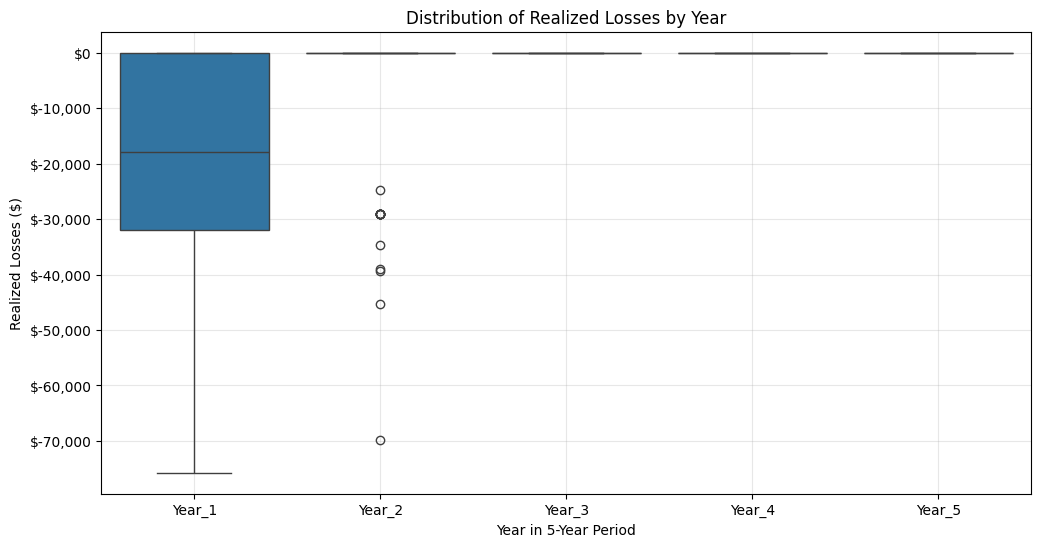

In [28]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt

def run_single_backtest(data, start_date, initial_investment=100000, loss_threshold=-0.05):
    """
    Run a single 5-year backtest starting from a specific date
    """
    # Get 5 years of data from start date
    end_date = start_date + relativedelta(years=5)
    mask = (data.index >= start_date) & (data.index < end_date)
    period_data = data[mask].copy()
    
    if len(period_data) < 100:  # Skip if insufficient data
        return None
    
    # Initialize tracking variables
    portfolio = pd.DataFrame(index=period_data.index)
    portfolio['Price'] = period_data['Adj Close']
    portfolio['Holdings'] = 0.0
    portfolio['Realized_Losses'] = 0.0
    
    # Initial purchase
    initial_price = portfolio['Price'].iloc[0]
    initial_coins = initial_investment / initial_price
    current_cost_basis = initial_price
    
    # Set initial positions
    portfolio.loc[portfolio.index[0], 'Holdings'] = initial_coins
    
    # Run simulation
    for i in range(1, len(portfolio)):
        current_price = portfolio['Price'].iloc[i]
        prev_holdings = portfolio['Holdings'].iloc[i-1]
        
        # Calculate current returns relative to cost basis
        current_return = (current_price - current_cost_basis) / current_cost_basis
        
        # Check if loss harvest threshold is met
        if current_return <= loss_threshold:
            realized_loss = (current_price - current_cost_basis) * prev_holdings
            portfolio.loc[portfolio.index[i], 'Realized_Losses'] = realized_loss
            current_cost_basis = current_price
        else:
            portfolio.loc[portfolio.index[i], 'Realized_Losses'] = 0
            
        portfolio.loc[portfolio.index[i], 'Holdings'] = prev_holdings
    
    # Calculate yearly losses
    yearly_losses = portfolio.resample('Y')['Realized_Losses'].sum()
    return yearly_losses

# Download complete BTC data
btc = yf.download('BTC-USD', start='2014-01-01')

# Generate all possible start dates (first day of each month)
start_dates = pd.date_range(start='2014-01-01', 
                           end='2019-01-01',  # End date that allows for 5 full years
                           freq='MS')  # MS = Month Start frequency

print("\nBacktest Start Dates:")
for date in start_dates:
    print(date.strftime('%Y-%m-%d'))

# Store results for each backtest
all_results = []

# Run backtests for each start date
for start_date in start_dates:
    result = run_single_backtest(btc, start_date)
    if result is not None:
        all_results.append({
            'start_date': start_date,
            'yearly_losses': result
        })

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

# Create a matrix of years (relative to start) and their losses
year_matrices = []
for _, row in results_df.iterrows():
    start_date = row['start_date']
    yearly_losses = row['yearly_losses']
    
    # Create a row for this backtest
    year_data = {}
    year_data['start_date'] = start_date
    for i, (date, loss) in enumerate(yearly_losses.items(), 1):
        year_data[f'Year_{i}'] = loss
        
    year_matrices.append(year_data)

# Convert to DataFrame for easier analysis
year_matrix_df = pd.DataFrame(year_matrices)

# Calculate summary statistics
summary_stats = pd.DataFrame({
    'Average_Loss': year_matrix_df.iloc[:, 1:].mean(),
    'Median_Loss': year_matrix_df.iloc[:, 1:].median(),
    'Std_Loss': year_matrix_df.iloc[:, 1:].std(),
    'Min_Loss': year_matrix_df.iloc[:, 1:].min(),
    'Max_Loss': year_matrix_df.iloc[:, 1:].max()
})

# Print results
print("\nSummary Statistics for Each Year of the 5-Year Period:")
print(summary_stats.round(2))

print("\nAverage Realized Losses by Year:")
for year in range(1, 6):
    avg_loss = year_matrix_df[f'Year_{year}'].mean()
    print(f"Year {year}: ${avg_loss:,.2f}")

# Calculate best and worst starting months
year_matrix_df['Total_Loss'] = year_matrix_df.iloc[:, 1:].sum(axis=1)
year_matrix_df['Start_Month'] = year_matrix_df['start_date'].dt.strftime('%B')

monthly_averages = year_matrix_df.groupby('Start_Month')['Total_Loss'].mean().sort_values()

print("\nAverage Total Realized Losses by Starting Month:")
for month, avg_loss in monthly_averages.items():
    print(f"{month}: ${avg_loss:,.2f}")

# Create box plot
plt.figure(figsize=(12, 6))
data_for_plot = pd.melt(year_matrix_df[['Year_1', 'Year_2', 'Year_3', 'Year_4', 'Year_5']])
sns.boxplot(x='variable', y='value', data=data_for_plot)
plt.title('Distribution of Realized Losses by Year')
plt.xlabel('Year in 5-Year Period')
plt.ylabel('Realized Losses ($)')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)

# Format y-axis labels to show millions
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,.0f}'.format(x) for x in current_values])

# Add median values on top of each box
medians = year_matrix_df[['Year 1', 'Year 2', 'Year 3', 'Year 4', 'Year 5']].median()
for i, median in enumerate(medians):
    plt.text(i, median, '${:,.0f}'.format(median), 
             horizontalalignment='center', 
             verticalalignment='bottom')

plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/1205064543.py:54: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_losses = portfolio.resample('Y')['Realized_Losses'].sum()



Backtest Start Dates:
2014-01-01
2014-02-01
2014-03-01
2014-04-01
2014-05-01
2014-06-01
2014-07-01
2014-08-01
2014-09-01
2014-10-01
2014-11-01
2014-12-01
2015-01-01
2015-02-01
2015-03-01
2015-04-01
2015-05-01
2015-06-01
2015-07-01
2015-08-01
2015-09-01
2015-10-01
2015-11-01
2015-12-01
2016-01-01
2016-02-01
2016-03-01
2016-04-01
2016-05-01
2016-06-01
2016-07-01
2016-08-01
2016-09-01
2016-10-01
2016-11-01
2016-12-01
2017-01-01
2017-02-01
2017-03-01
2017-04-01
2017-05-01
2017-06-01
2017-07-01
2017-08-01
2017-09-01
2017-10-01
2017-11-01
2017-12-01
2018-01-01
2018-02-01
2018-03-01
2018-04-01
2018-05-01
2018-06-01
2018-07-01
2018-08-01
2018-09-01
2018-10-01
2018-11-01
2018-12-01
2019-01-01
2019-02-01
2019-03-01
2019-04-01
2019-05-01
2019-06-01
2019-07-01
2019-08-01
2019-09-01
2019-10-01
2019-11-01
2019-12-01
2020-01-01
2020-02-01
2020-03-01
2020-04-01
2020-05-01
2020-06-01
2020-07-01
2020-08-01
2020-09-01
2020-10-01
2020-11-01
2020-12-01
2021-01-01
2021-02-01
2021-03-01
2021-04-01
2021-05-0

/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/1205064543.py:54: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_losses = portfolio.resample('Y')['Realized_Losses'].sum()
/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/1205064543.py:54: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_losses = portfolio.resample('Y')['Realized_Losses'].sum()
/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/1205064543.py:54: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_losses = portfolio.resample('Y')['Realized_Losses'].sum()
/var/folders/n0/sfmyrcz17zx1dt9q70j71zs40000gn/T/ipykernel_82920/1205064543.py:54: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_losses = portfolio.resample('Y')['Realized_Losses'].sum()
/var


Summary Statistics for Each Year of the 5-Year Period:
        Average_Loss  Median_Loss  Std_Loss  Min_Loss  Max_Loss
Year_1     -20411.52    -16404.46  20512.51 -75736.77       0.0
Year_2      -9843.84         0.00  17291.07 -69808.69       0.0
Year_3       -143.90         0.00   1495.46 -15541.23       0.0
Year_4          0.00         0.00      0.00      0.00       0.0
Year_5          0.00         0.00      0.00      0.00       0.0
Year_6          0.00         0.00      0.00      0.00       0.0

Average Realized Losses by Year:
Year 1: $-20,411.52
Year 2: $-9,843.84
Year 3: $-143.90
Year 4: $0.00

Average Total Realized Losses by Starting Month:
January: $-36,948.52
March: $-36,360.69
August: $-32,478.50
February: $-31,003.48
July: $-30,554.89
September: $-30,255.55
June: $-30,214.78
November: $-29,280.44
May: $-27,927.08
April: $-27,765.85
December: $-26,506.28
October: $-25,322.40


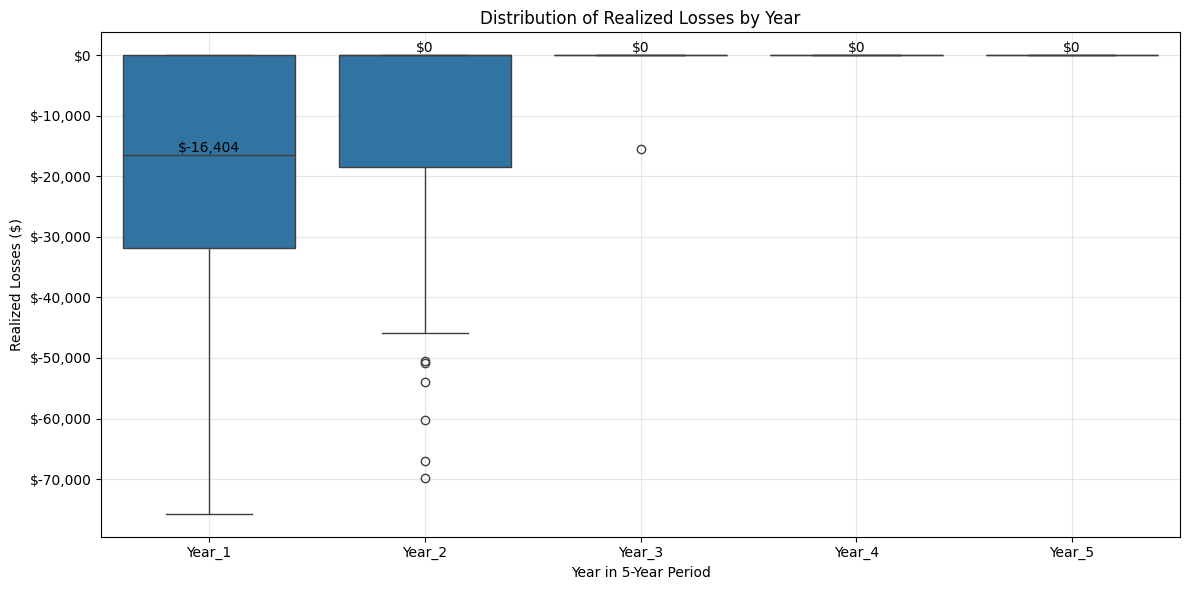

In [40]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt

def run_single_backtest(data, start_date, initial_investment=100000, loss_threshold=-0.05):
    """
    Run a single 5-year backtest starting from a specific date
    """
    # Get 5 years of data from start date
    end_date = start_date + relativedelta(years=5)
    mask = (data.index >= start_date) & (data.index < end_date)
    period_data = data[mask].copy()
    
    if len(period_data) < 100:  # Skip if insufficient data
        return None
    
    # Initialize tracking variables
    portfolio = pd.DataFrame(index=period_data.index)
    portfolio['Price'] = period_data['Adj Close']
    portfolio['Holdings'] = 0.0
    portfolio['Realized_Losses'] = 0.0
    
    # Initial purchase
    initial_price = portfolio['Price'].iloc[0]
    initial_coins = initial_investment / initial_price
    current_cost_basis = initial_price
    
    # Set initial positions
    portfolio.loc[portfolio.index[0], 'Holdings'] = initial_coins
    
    # Run simulation
    for i in range(1, len(portfolio)):
        current_price = portfolio['Price'].iloc[i]
        prev_holdings = portfolio['Holdings'].iloc[i-1]
        
        # Calculate current returns relative to cost basis
        current_return = (current_price - current_cost_basis) / current_cost_basis
        
        # Check if loss harvest threshold is met
        if current_return <= loss_threshold:
            realized_loss = (current_price - current_cost_basis) * prev_holdings
            portfolio.loc[portfolio.index[i], 'Realized_Losses'] = realized_loss
            current_cost_basis = current_price
        else:
            portfolio.loc[portfolio.index[i], 'Realized_Losses'] = 0
            
        portfolio.loc[portfolio.index[i], 'Holdings'] = prev_holdings
    
    # Calculate yearly losses
    yearly_losses = portfolio.resample('Y')['Realized_Losses'].sum()
    return yearly_losses

# Download complete BTC data
btc = yf.download('BTC-USD', start='2014-01-01')

# Generate all possible start dates (first day of each month)
start_dates = pd.date_range(start='2014-01-01', 
                           end='2023-12-01',  # End date that allows for 5 full years
                           freq='MS')  # MS = Month Start frequency

print("\nBacktest Start Dates:")
for date in start_dates:
    print(date.strftime('%Y-%m-%d'))

# Store results for each backtest
all_results = []

# Run backtests for each start date
for start_date in start_dates:
    result = run_single_backtest(btc, start_date)
    if result is not None:
        all_results.append({
            'start_date': start_date,
            'yearly_losses': result
        })

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

# Create a matrix of years (relative to start) and their losses
year_matrices = []
for _, row in results_df.iterrows():
    start_date = row['start_date']
    yearly_losses = row['yearly_losses']
    
    # Create a row for this backtest
    year_data = {}
    year_data['start_date'] = start_date
    for i, (date, loss) in enumerate(yearly_losses.items(), 1):
        year_data[f'Year_{i}'] = loss
        
    year_matrices.append(year_data)

# Convert to DataFrame for easier analysis
year_matrix_df = pd.DataFrame(year_matrices)

# Calculate summary statistics
summary_stats = pd.DataFrame({
    'Average_Loss': year_matrix_df.iloc[:, 1:].mean(),
    'Median_Loss': year_matrix_df.iloc[:, 1:].median(),
    'Std_Loss': year_matrix_df.iloc[:, 1:].std(),
    'Min_Loss': year_matrix_df.iloc[:, 1:].min(),
    'Max_Loss': year_matrix_df.iloc[:, 1:].max()
})

# Print results
print("\nSummary Statistics for Each Year of the 5-Year Period:")
print(summary_stats.round(2))

print("\nAverage Realized Losses by Year:")
for year in range(1, 5):
    avg_loss = year_matrix_df[f'Year_{year}'].mean()
    print(f"Year {year}: ${avg_loss:,.2f}")

# Calculate best and worst starting months
year_matrix_df['Total_Loss'] = year_matrix_df.iloc[:, 1:].sum(axis=1)
year_matrix_df['Start_Month'] = year_matrix_df['start_date'].dt.strftime('%B')

monthly_averages = year_matrix_df.groupby('Start_Month')['Total_Loss'].mean().sort_values()

print("\nAverage Total Realized Losses by Starting Month:")
for month, avg_loss in monthly_averages.items():
    print(f"{month}: ${avg_loss:,.2f}")

# Create box plot
plt.figure(figsize=(12, 6))
data_for_plot = pd.melt(year_matrix_df[['Year_1', 'Year_2', 'Year_3', 'Year_4', 'Year_5']])
sns.boxplot(x='variable', y='value', data=data_for_plot)
plt.title('Distribution of Realized Losses by Year')
plt.xlabel('Year in 5-Year Period')
plt.ylabel('Realized Losses ($)')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)

# Format y-axis labels to show millions
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,.0f}'.format(x) for x in current_values])

# Add median values on top of each box
medians = year_matrix_df[['Year_1', 'Year_2', 'Year_3', 'Year_4', 'Year_5']].median()
for i, median in enumerate(medians):
    plt.text(i, median, '${:,.0f}'.format(median), 
             horizontalalignment='center', 
             verticalalignment='bottom')

plt.tight_layout()
plt.show()